In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(r'C:\Users\Emincan\Desktop\Gdz\gdz-competition\Önemli Scriptler')

# Data Read

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

train_df = pd.read_csv('train.csv')
submit_df = pd.read_csv('sample_submission.csv')
med_df = pd.read_csv('med.csv')

# Feature Engineering

In [3]:
med_df["Yıl"] = pd.to_datetime(med_df["Tarih"]).dt.year
med_df["Ay"] = pd.to_datetime(med_df["Tarih"]).dt.month
med_df["Gün"] = pd.to_datetime(med_df["Tarih"]).dt.day

train_df["Yıl"] = pd.to_datetime(train_df["Tarih"]).dt.year
train_df["Ay"] = pd.to_datetime(train_df["Tarih"]).dt.month
train_df["Gün"] = pd.to_datetime(train_df["Tarih"]).dt.day
train_df["Saat"] = pd.to_datetime(train_df["Tarih"]).dt.hour

submit_df["Yıl"] = pd.to_datetime(submit_df["Tarih"]).dt.year
submit_df["Ay"] = pd.to_datetime(submit_df["Tarih"]).dt.month
submit_df["Gün"] = pd.to_datetime(submit_df["Tarih"]).dt.day
submit_df["Saat"] = pd.to_datetime(submit_df["Tarih"]).dt.hour
submit_df["Kesintili Günler"]=0

train_df = train_df.drop("Tarih", axis=1)
submit_df = submit_df.drop("Tarih", axis=1)
med_df = med_df.drop("Tarih", axis=1)

med_df[['Yıl', 'Ay', 'Gün']] = med_df[['Yıl', 'Ay', 'Gün']].astype(int)
train_df['Kesintili Günler'] = train_df.apply(lambda row: int((row[['Yıl', 'Ay', 'Gün']] == med_df[['Yıl', 'Ay', 'Gün']]).all(axis=1).any()), axis=1)

In [4]:
calendar = pd.read_csv('Turkish_calendar.csv',sep=(";"))
new_df = calendar.iloc[853:2557].copy()
new_df.loc[:, "Ay"] = pd.to_datetime(new_df["CALENDAR_DATE"], format="%d.%m.%Y").dt.month
new_df.loc[:, "Yıl"] = pd.to_datetime(new_df["CALENDAR_DATE"], format="%d.%m.%Y").dt.year
new_df = new_df.drop(["SEASON_SK", "SPECIAL_DAY_SK", "SPECIAL_DAY_SK2"], axis=1)

In [5]:
new_df["WEEKEND_FLAG"] =new_df["WEEKEND_FLAG"].replace(["N"],0)
new_df["WEEKEND_FLAG"] =new_df["WEEKEND_FLAG"].replace(["Y"],1)
new_df["RAMADAN_FLAG"] =new_df["RAMADAN_FLAG"].replace(["N"],0)
new_df["RAMADAN_FLAG"] =new_df["RAMADAN_FLAG"].replace(["Y"],1)
new_df["PUBLIC_HOLIDAY_FLAG"] =new_df["PUBLIC_HOLIDAY_FLAG"].replace(["N"],0)
new_df["PUBLIC_HOLIDAY_FLAG"] =new_df["PUBLIC_HOLIDAY_FLAG"].replace(["Y"],1)

In [6]:
new_df.rename(columns={'DAY_OF_MONTH': 'Gün'}, inplace=True)
new_df.rename(columns={'DAY_OF_WEEK_SK': 'Haftanın Günü'}, inplace=True)
new_df.rename(columns={'QUARTER_OF_YEAR': 'Sezon'}, inplace=True)
new_df.rename(columns={'WEEKEND_FLAG': 'Haftasonu - Haftaiçi'}, inplace=True)
new_df.rename(columns={'WEEK_OF_YEAR': 'Yılın kaçıncı haftası'}, inplace=True)
new_df.rename(columns={'RAMADAN_FLAG': 'Ramazan'}, inplace=True)
new_df.rename(columns={'RELIGIOUS_DAY_FLAG_SK': 'Dini Gün'}, inplace=True)
new_df.rename(columns={'NATIONAL_DAY_FLAG_SK': 'Ulusal Gün'}, inplace=True)
new_df.rename(columns={'PUBLIC_HOLIDAY_FLAG': 'Resmi tatil'}, inplace=True)

In [7]:
new_df_submit=new_df.iloc[0:31]
new_df_train=new_df.iloc[31:1704]
merged_df = pd.merge(train_df, new_df_train, on=["Yıl", "Ay", "Gün"])
merged_df2 = pd.merge(submit_df, new_df_submit, on=["Yıl", "Ay", "Gün"])

# Train | Test Split

In [8]:
X=merged_df.drop("Dağıtılan Enerji (MWh)", axis=1)
X=X.drop("CALENDAR_DATE", axis=1)
y=merged_df["Dağıtılan Enerji (MWh)"]
forecast=merged_df2.drop("Dağıtılan Enerji (MWh)", axis=1)
forecast=forecast.drop("CALENDAR_DATE", axis=1)

In [9]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2 , random_state=53)

# Modelling

## Randomized Search CatBoost

In [11]:
# from catboost import CatBoostRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform, randint

# params = {
#     'learning_rate': uniform(0.01, 0.1),
#     'max_depth': randint(3, 10),
#     'l2_leaf_reg': uniform(0, 1),
#     'subsample': uniform(0.5, 0.5),
#     'colsample_bylevel': uniform(0.5, 0.5),
#     'random_strength': uniform(0, 1),
# }

# model = CatBoostRegressor(loss_function='MAPE',
#                           eval_metric='MAPE',
#                         #   task_type='GPU',
#                           devices='GPU:0',
#                           iterations=5000)

# random_search = RandomizedSearchCV(estimator=model,
#                                    param_distributions=params,
#                                    n_iter=100,
#                                    cv=3,
#                                    scoring='neg_mean_absolute_percentage_error',
#                                    verbose=0,
#                                    random_state=53,
#                                    )

# random_search.fit(X_train, y_train)

# print(f"""
#       En iyi CatBoost parametreleri : {random_search.best_params_}
#       En iyi MAPE skorumuz : {-random_search.best_score_}
#       """)


In [12]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

cat = CatBoostRegressor(loss_function='MAPE' , eval_metric='MAPE' , task_type='GPU' , devices='GPU')

params = {'learning_rate' : np.arange(0.01,1,0.05),
          'depth' : np.arange(8,20),
          'l2_leaf_reg' : [1,3,5,7,9,11,13]}

randomized_searchs = cat.randomized_search(params,X_train,y_train,cv = 3 , n_iter = 10)

0:	learn: 0.9999999	test: 0.9999998	best: 0.9999998 (0)	total: 12.3ms	remaining: 12.3s
1:	learn: 0.9999995	test: 0.9999995	best: 0.9999995 (1)	total: 19.3ms	remaining: 9.61s
2:	learn: 0.9999995	test: 0.9999991	best: 0.9999991 (2)	total: 30.6ms	remaining: 10.2s
3:	learn: 0.9999987	test: 0.9999989	best: 0.9999989 (3)	total: 40ms	remaining: 9.96s
4:	learn: 0.9999985	test: 0.9999986	best: 0.9999986 (4)	total: 46.9ms	remaining: 9.34s
5:	learn: 0.9999982	test: 0.9999984	best: 0.9999984 (5)	total: 54.5ms	remaining: 9.02s
6:	learn: 0.9999980	test: 0.9999981	best: 0.9999981 (6)	total: 60ms	remaining: 8.52s
7:	learn: 0.9999980	test: 0.9999979	best: 0.9999979 (7)	total: 69ms	remaining: 8.56s
8:	learn: 0.9999976	test: 0.9999976	best: 0.9999976 (8)	total: 74.5ms	remaining: 8.2s
9:	learn: 0.9999974	test: 0.9999972	best: 0.9999972 (9)	total: 81.5ms	remaining: 8.07s
10:	learn: 0.9999967	test: 0.9999970	best: 0.9999970 (10)	total: 87.8ms	remaining: 7.89s
11:	learn: 0.9999964	test: 0.9999967	best: 0.999

In [25]:
print(f"""
      En iyi CatBoost parametreleri : {randomized_searchs['params']}
      """)


      En iyi CatBoost parametreleri : {'depth': 15, 'l2_leaf_reg': 11, 'learning_rate': 0.96}
      


In [26]:
# randomized_searchs

# Modelling Time

In [27]:
from eval_metrics import eval_metrics

In [28]:
# model = CatBoostRegressor(iterations=2200, learning_rate=0.6352, depth=6,l2_leaf_reg=7,colsample_bylevel= 0.5352, loss_function='MAPE', bootstrap_type='MVS')
# model = CatBoostRegressor(iterations=1800, subsample=0.4, learning_rate=0.075, depth=16, l2_leaf_reg= 4,colsample_bylevel= 1, loss_function='MAPE', bootstrap_type='MVS')
model = CatBoostRegressor(learning_rate=0.96, depth=15, l2_leaf_reg= 11,loss_function='MAPE')

In [ ]:
# model = CatBoostRegressor(iterations=5000, learning_rate=0.086, depth=9,l2_leaf_reg=0.6,colsample_bylevel= 0.67, loss_function='MAPE', subsample=0.68 , devices='GPU:0')

In [29]:
model.fit(X_train,y_train , verbose= False)

In [30]:
y_pred = model.predict(X_test)
eval_metrics(y_test , y_pred)


          Mape Score : 0.05373398594493733
          R2 Score : 0.8894962577563694
          MAE Score : 98.87197603799876
          MSE Score : 142.09133991104483
          


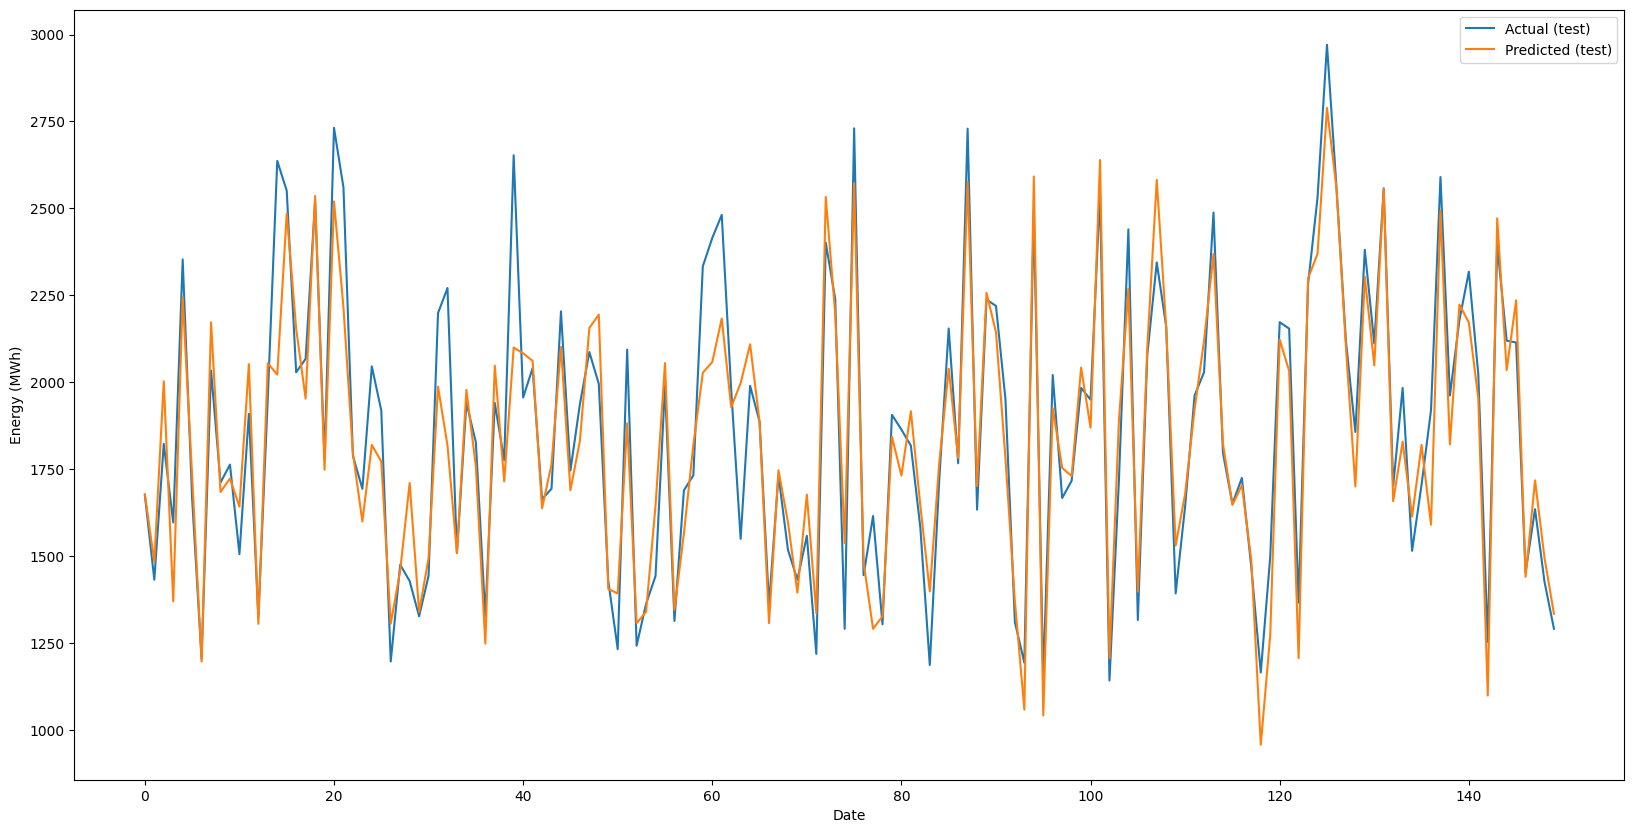

In [31]:
fig = plt.figure(figsize=(20, 10))
# Tahminleri ve gerçek değerleri görselleştir
plt.plot(forecast.index[:150], y_test[:150], label='Actual (test)')
plt.plot(forecast.index[:150], y_pred[:150], label='Predicted (test)')

plt.xlabel('Date')
plt.ylabel('Energy (MWh)')
plt.legend()
plt.show()

# Final Model

In [33]:
cat_final = CatBoostRegressor(learning_rate=0.96, depth=15, l2_leaf_reg= 11,loss_function='MAPE' , devices='GPU:0' , task_type= 'GPU' )

In [34]:
cat_final.fit(X,y , verbose= False)

In [35]:
y_pred = cat_final.predict(X_test)
eval_metrics(y_test , y_pred)


          Mape Score : 0.1946019298748773
          R2 Score : -0.08218301388590676
          MAE Score : 356.9943154029045
          MSE Score : 444.6614431895129
          


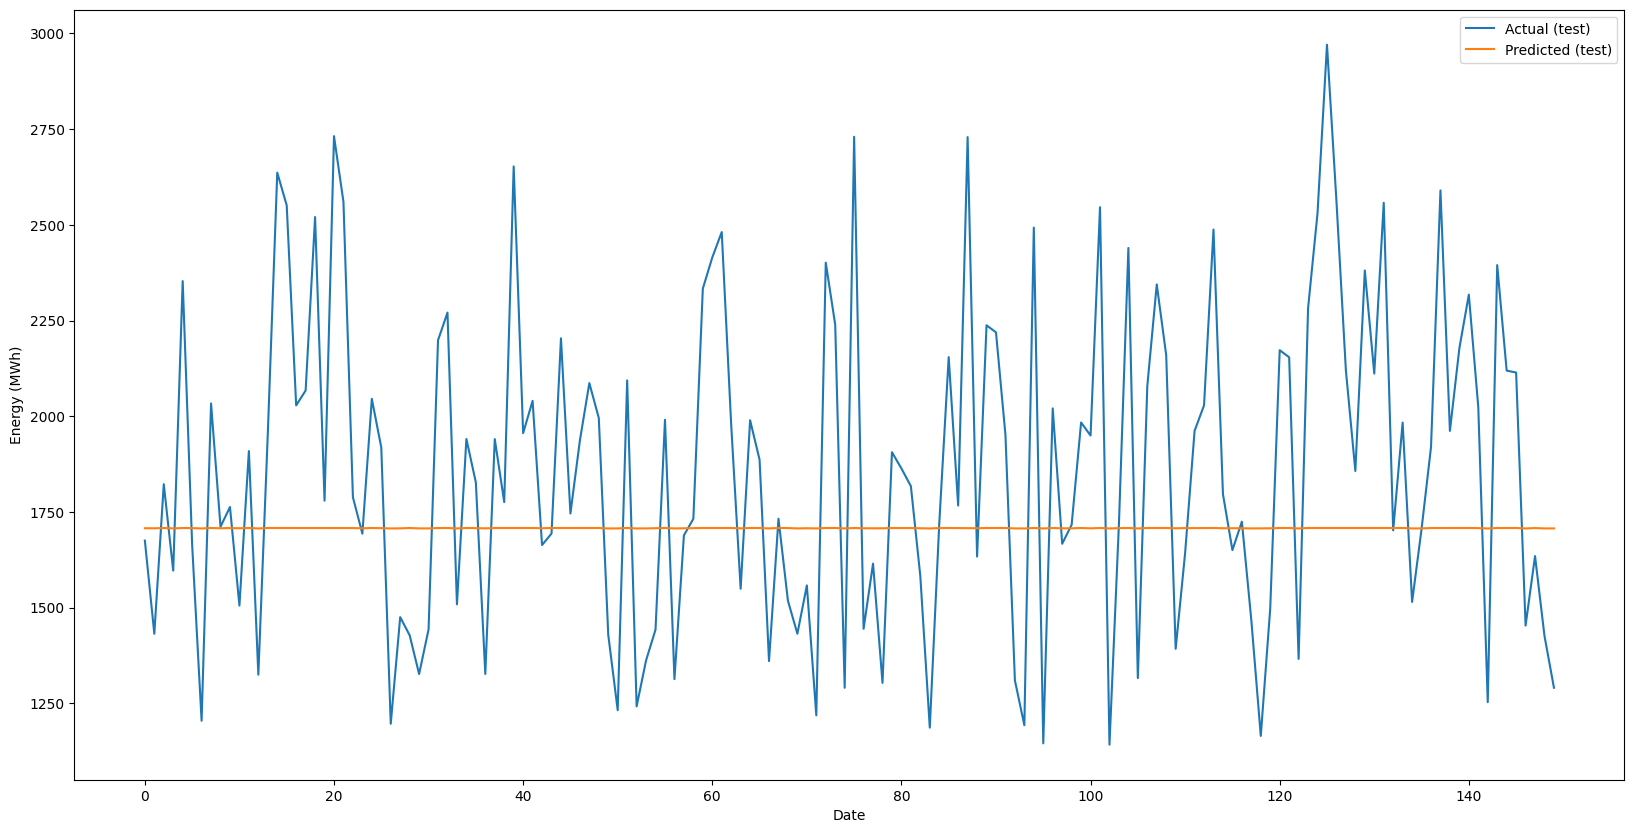

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
# Tahminleri ve gerçek değerleri görselleştir
plt.plot(forecast.index[:150], y_test[:150], label='Actual (test)')
plt.plot(forecast.index[:150], y_pred[:150], label='Predicted (test)')

plt.xlabel('Date')
plt.ylabel('Energy (MWh)')
plt.legend()
plt.show()

# Forecasts

In [ ]:
y_forecast_final = cat_final.predict(forecast)
y_forecast_final[:10]

# Visualize Predictions

In [ ]:
from eval_metrics import preds_plot

In [ ]:
y_forecast_final = cat_final.predict(forecast)
y_forecast_final[:10]

In [ ]:
future_data= pd.read_csv('sample_submission.csv')
future_data["Dağıtılan Enerji (MWh)"]=y_forecast_final
submit_data = future_data.copy()

In [ ]:
future_data = future_data.set_index('Tarih', drop=True)
future_data.index = future_data.index.astype('datetime64')
future_data

In [ ]:
data = pd.read_csv('train.csv' , parse_dates=['Tarih'] , index_col='Tarih')
data

In [ ]:
target_data = data[data.index.month == 8]
target_data

In [ ]:
plt.figure(figsize= ( 16 , 8))

preds_plot(data , future_data , target_data)

In [ ]:
submit_data.to_csv(r"C:\Users\Emincan\Desktop\Gdz\gdz-competition\Büyük Modeller\XGBoost\Predicts-Images\XGB-3200-maxd8-lr019-gamma04-colsamp0.9-subsamp0.9-minchild2.csv",index=None)